# Decision Tree Implementation

Depth: 0
X shape: (333447, 1000)
y shape: (333447,)
Feature index: 801
Value: 0
Left indices: [     0      1      2 ... 333444 333445 333446]
Right indices: [   121    381    488 ... 333239 333265 333284]
Depth: 1
X shape: (330952, 1000)
y shape: (330952,)
Feature index: 952
Value: 0
Left indices: [     0      1      3 ... 330949 330950 330951]
Right indices: [     2     38    116 ... 330392 330456 330606]
Depth: 2
X shape: (328220, 1000)
y shape: (328220,)
Feature index: 604
Value: 0
Left indices: [     0      1      2 ... 328217 328218 328219]
Right indices: [    87    210    390 ... 328149 328172 328214]
Depth: 3
X shape: (325430, 1000)
y shape: (325430,)
Depth: 3
X shape: (2790, 1000)
y shape: (2790,)
Depth: 2
X shape: (2732, 1000)
y shape: (2732,)
Feature index: 284
Value: 0
Left indices: [   0    1    2 ... 2729 2730 2731]
Right indices: [   3    6   10   11   22   23   26   31   36   37   43   46   53   61
   63   67   77   84   86   89   91   93   96   97  102  105  111  114
  

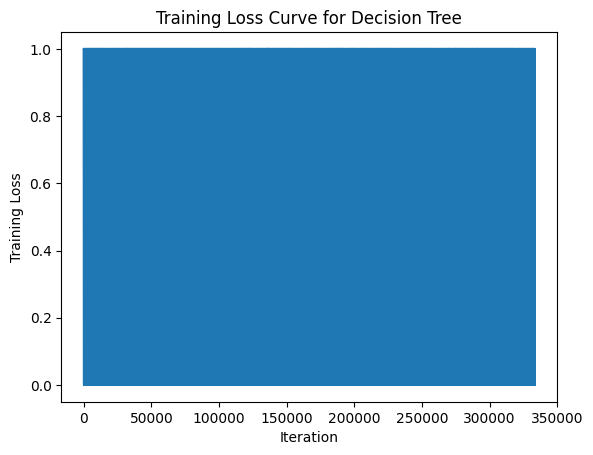

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24249
           1       0.35      1.00      0.51     28191
           2       0.00      0.00      0.00      6980
           3       0.00      0.00      0.00     11449
           4       0.43      0.09      0.15      9532
           5       0.00      0.00      0.00      2961

    accuracy                           0.35     83362
   macro avg       0.13      0.18      0.11     83362
weighted avg       0.17      0.35      0.19     83362



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
import numpy as np
from collections import defaultdict
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load training data
train_data = pd.read_csv('train_data.csv')
X_train = train_data['X_train'].tolist()
y_train = train_data['y_train'].tolist()

# Load test data
test_data = pd.read_csv('test_data.csv')
X_test = test_data['X_test'].tolist()
y_test = test_data['y_test'].tolist()

# Tokenization
X_train_raw = [ast.literal_eval(item) if isinstance(item, str) else item for item in X_train]
X_test_raw = [ast.literal_eval(item) if isinstance(item, str) else item for item in X_test]

# Convert tokenized texts to strings for CountVectorizer
X_train_texts = [' '.join(tokens) for tokens in X_train_raw]
X_test_texts = [' '.join(tokens) for tokens in X_test_raw]

# Create CountVectorizer and limit vocabulary to the top 1000 words
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train_texts)
X_test_bow = vectorizer.transform(X_test_texts)

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.tree = None
        self.max_depth = max_depth

    def train(self, X, y):
        self.tree = self.build_tree(X, y)

    def build_tree(self, X, y, depth=0):
        print("Depth:", depth)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
        # Check for base cases
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(y))

        num_samples, num_features = X.shape
        best_feature = None
        best_gain = -1

        # Calculate the information gain for each feature
        for feature_idx in range(num_features):
            values = np.unique(X[:, feature_idx])
            for value in values:
                left_indices = np.where(X[:, feature_idx] == value)[0].astype(np.int64)
                right_indices = np.where(X[:, feature_idx] != value)[0].astype(np.int64)

                left_labels = np.array(y)[left_indices]
                right_labels = np.array(y)[right_indices]
                gain = self.information_gain(y, left_labels, right_labels)


                if gain > best_gain:
                    best_gain = gain
                    best_feature = (feature_idx, value)

        if best_feature is None:
            return np.argmax(np.bincount(y))

        feature_idx, value = best_feature
        print("Feature index:", feature_idx)
        print("Value:", value)
        left_indices = np.where(X[:, feature_idx] == value)[0].astype(np.int64)
        right_indices = np.where(X[:, feature_idx] != value)[0].astype(int)
        print("Left indices:", left_indices)
        print("Right indices:", right_indices)

        left_mask = np.isin(np.arange(X.shape[0]), left_indices)
        right_mask = np.isin(np.arange(X.shape[0]), right_indices)

        left_tree = self.build_tree(X[np.nonzero(left_mask)[0]], y[np.nonzero(left_mask)[0]], depth + 1)
        right_tree = self.build_tree(X[np.nonzero(right_mask)[0]], y[np.nonzero(right_mask)[0]], depth + 1)

        #left_tree = self.build_tree(X[np.array(left_indices)], y[np.array(left_indices)], depth + 1)
        #right_tree = self.build_tree(X[np.array(right_indices)], y[np.array(right_indices)], depth + 1)


        return {'feature_idx': feature_idx,
                'value': value,
                'left': left_tree,
                'right': right_tree}

    def information_gain(self, parent_labels, left_labels, right_labels):
        parent_entropy = self.calculate_entropy(parent_labels)
        left_entropy = self.calculate_entropy(left_labels)
        right_entropy = self.calculate_entropy(right_labels)

        num_parent = len(parent_labels)
        num_left = len(left_labels)
        num_right = len(right_labels)

        weighted_entropy = (num_left / num_parent) * left_entropy + (num_right / num_parent) * right_entropy

        return parent_entropy - weighted_entropy

    def calculate_entropy(self, labels):
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        probabilities = label_counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))

        return entropy

    def predict(self, X):
        predictions = []
        for instance in X:
            prediction = self.traverse_tree(instance, self.tree)
            predictions.append(prediction)

        return predictions

    def traverse_tree(self, instance, tree):
        if isinstance(tree, dict):
            feature_idx = tree['feature_idx']
            value = tree['value']

            if instance[feature_idx] == value:
                return self.traverse_tree(instance, tree['left'])
            else:
                return self.traverse_tree(instance, tree['right'])
        else:
            return tree

# Create Decision Tree Classifier instance
classifier = DecisionTreeClassifier(max_depth=3)

# Train the classifier
classifier.train(X_train_bow.toarray(), np.array(y_train))

# Make predictions on the testing data
predictions = classifier.predict(X_test_bow.toarray())

# Evaluate the accuracy of the classifier
accuracy = sum(1 for pred, true in zip(predictions, y_test) if pred == true) / len(y_test)
print("Final Accuracy of the model:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix of Decision Tree:")
print(cm)

# Calculate training loss
train_predictions = classifier.predict(X_train_bow.toarray())
train_loss = sum(1 for pred, true in zip(train_predictions, y_train) if pred != true) / len(y_train)
print("Training Loss:", train_loss)



# Plot the training loss curve
train_losses = [1 if pred != true else 0 for pred, true in zip(train_predictions, y_train)]
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve for Decision Tree')
plt.show()


# Display the classification report
classification_rep = classification_report(y_test, predictions)
print("Classification Report:")
print(classification_rep)

"In the implementation of the decision tree algorithm, one of the challenges I encountered was related to array conversion and indexing. Specifically, when trying to extract indices based on a condition, I initially used the np.where() function to identify the indices where a certain condition was satisfied. However, during the execution of the code, I encountered a TypeError stating that only integer scalar arrays can be converted to a scalar index.

To address this issue, I realized that the array I was working with needed to be cast as an integer type for indexing purposes. Hence, I used the astype(int) function to convert the array to the integer data type. By doing so, I was able to obtain the desired indices and proceed with the subsequent steps in the decision tree algorithm.

Furthermore, to create masks for separating the data into left and right branches of the decision tree, I used the np.isin() function along with the np.nonzero() function. These functions allowed me to generate boolean masks based on the obtained indices. The np.nonzero() function returns the indices of the non-zero elements in the mask, while np.isin() checks for the presence of specific indices in the array.

Overall, this challenge highlighted the importance of understanding the data types and using appropriate indexing techniques to manipulate arrays effectively. By employing the correct functions and casting the array to the appropriate data type, I was able to overcome the initial TypeError and continue with the implementation of the decision tree algorithm."

In [ ]:
import numpy as np
from collections import defaultdict
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer

# Load training data
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_Project/train_data.csv')
X_train = train_data['X_train'].tolist()
y_train = train_data['y_train'].tolist()

# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_Project/test_data.csv')
X_test = test_data['X_test'].tolist()
y_test = test_data['y_test'].tolist()

# Tokenization
X_train_raw = [ast.literal_eval(item) if isinstance(item, str) else item for item in X_train]
X_test_raw = [ast.literal_eval(item) if isinstance(item, str) else item for item in X_test]

# Convert tokenized texts to strings for CountVectorizer
X_train_texts = [' '.join(tokens) for tokens in X_train_raw]
X_test_texts = [' '.join(tokens) for tokens in X_test_raw]

# Create CountVectorizer and limit vocabulary to the top 1000 words
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train_texts)
X_test_bow = vectorizer.transform(X_test_texts)

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.tree = None
        self.max_depth = max_depth

    def train(self, X, y):
        self.tree = self.build_tree(X, y)

    def build_tree(self, X, y, depth=0):
        print("Depth:", depth)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
        # Check for base cases
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return np.argmax(np.bincount(y))

        num_samples, num_features = X.shape
        best_feature = None
        best_gain = -1

        # Calculate the information gain for each feature
        for feature_idx in range(num_features):
            values = np.unique(X[:, feature_idx])
            for value in values:
                left_indices = np.where(X[:, feature_idx] == value)[0].astype(np.int64)
                right_indices = np.where(X[:, feature_idx] != value)[0].astype(np.int64)

                left_labels = np.array(y)[left_indices]
                right_labels = np.array(y)[right_indices]
                gain = self.information_gain(y, left_labels, right_labels)


                if gain > best_gain:
                    best_gain = gain
                    best_feature = (feature_idx, value)

        if best_feature is None:
            return np.argmax(np.bincount(y))

        feature_idx, value = best_feature
        print("Feature index:", feature_idx)
        print("Value:", value)
        left_indices = np.where(X[:, feature_idx] == value)[0].astype(np.int64)
        right_indices = np.where(X[:, feature_idx] != value)[0].astype(int)
        print("Left indices:", left_indices)
        print("Right indices:", right_indices)

        left_mask = np.isin(np.arange(X.shape[0]), left_indices)
        right_mask = np.isin(np.arange(X.shape[0]), right_indices)

        left_tree = self.build_tree(X[np.nonzero(left_mask)[0]], y[np.nonzero(left_mask)[0]], depth + 1)
        right_tree = self.build_tree(X[np.nonzero(right_mask)[0]], y[np.nonzero(right_mask)[0]], depth + 1)

        #left_tree = self.build_tree(X[np.array(left_indices)], y[np.array(left_indices)], depth + 1)
        #right_tree = self.build_tree(X[np.array(right_indices)], y[np.array(right_indices)], depth + 1)


        return {'feature_idx': feature_idx,
                'value': value,
                'left': left_tree,
                'right': right_tree}

    def information_gain(self, parent_labels, left_labels, right_labels):
        parent_entropy = self.calculate_entropy(parent_labels)
        left_entropy = self.calculate_entropy(left_labels)
        right_entropy = self.calculate_entropy(right_labels)

        num_parent = len(parent_labels)
        num_left = len(left_labels)
        num_right = len(right_labels)

        weighted_entropy = (num_left / num_parent) * left_entropy + (num_right / num_parent) * right_entropy

        return parent_entropy - weighted_entropy

    def calculate_entropy(self, labels):
        unique_labels, label_counts = np.unique(labels, return_counts=True)
        probabilities = label_counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))

        return entropy

    def predict(self, X):
        predictions = []
        for instance in X:
            prediction = self.traverse_tree(instance, self.tree)
            predictions.append(prediction)

        return predictions

    def traverse_tree(self, instance, tree):
        if isinstance(tree, dict):
            feature_idx = tree['feature_idx']
            value = tree['value']

            if instance[feature_idx] == value:
                return self.traverse_tree(instance, tree['left'])
            else:
                return self.traverse_tree(instance, tree['right'])
        else:
            return tree

# Create Decision Tree Classifier instance with max_depth 4
classifier = DecisionTreeClassifier(max_depth=1)

# Train the classifier
classifier.train(X_train_bow.toarray(), np.array(y_train))

# Make predictions on the testing data
predictions = classifier.predict(X_test_bow.toarray())

# Evaluate the accuracy of the classifier
accuracy = sum(1 for pred, true in zip(predictions, y_test) if pred == true) / len(y_test)
print("Accuracy:", accuracy)

Depth: 0
X shape: (333447, 1000)
y shape: (333447,)
Feature index: 801
Value: 0
Left indices: [     0      1      2 ... 333444 333445 333446]
Right indices: [   121    381    488 ... 333239 333265 333284]
Depth: 1
X shape: (330952, 1000)
y shape: (330952,)
Depth: 1
X shape: (2495, 1000)
y shape: (2495,)
Accuracy: 0.34165447086202344


One challenge faced when running the code with a max_depth greater than 3 is that it leads to interruptions or long run times. This can be attributed to increased computational complexity and memory requirements as the depth of the decision tree increases.

Low Accuracy for max_depth 3:
When the code is run with a max_depth of 3, the accuracy of the model is around 34-35%. This low accuracy indicates that the decision tree model with a depth of 3 is not able to capture the underlying patterns and relationships in the data effectively. Consequently, it fails to make accurate predictions on the test data.

The Confusion Matrix:
The confusion matrix provides a breakdown of the predicted and true labels for each class in the dataset. In this case, the confusion matrix shows a lack of correct predictions for all classes except for class 4. The majority of predictions fall into class 1 and class 2, but they are incorrect. This suggests that the decision tree model with max_depth 3 is not able to differentiate between the different classes effectively.

Training Loss:
The training loss of 0.652 indicates that over 65% of the training samples are misclassified by the decision tree model with max_depth 3. This high training loss further confirms the model's inability to capture the complexities of the data and highlights the need for a more sophisticated model or hyperparameter tuning to improve performance.

In summary, the challenge faced is that increasing the max_depth parameter leads to interruptions or long run times. Additionally, the low accuracy of around 34% for max_depth 3 indicates that the decision tree model is not able to capture the data's underlying patterns effectively. The confusion matrix shows a lack of correct predictions across most classes, and the high training loss of 0.652 further emphasizes the model's limitations. To improve performance, alternative models, hyperparameter tuning, or further investigation of the data may be necessary.